In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py310hff52083_0         895 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         933 KB

The following NEW packages will be INSTALLED:

  filelock  

In [3]:
!gdown --id 1qo7Ov82N3rpfpgwLNYZLS-O8tRoegpxm

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qo7Ov82N3rpfpgwLNYZLS-O8tRoegpxm
To: /kaggle/working/CAPTCHA_Images.zip
100%|██████████████████████████████████████| 18.3M/18.3M [00:00<00:00, 89.1MB/s]


In [4]:
import zipfile
z= zipfile.ZipFile('CAPTCHA_Images.zip')
z.extractall()

# Libraries

In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, SpatialDropout2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import random

# Main execution

In [6]:
folder_path = "/kaggle/working/samples"

# Set the maximum number of images to process

In [7]:
MAX_IMAGES = 5000  # Adjust this number based on your RAM capacity

# Preprocessing Image

In [8]:
def preprocess_image(img):
    """Enhanced image preprocessing pipeline."""
    if img is None:
        raise ValueError("Image not loaded properly")
    
    # Resize image
    img = cv2.resize(img, (160, 80))  # Higher resolution
    
    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    
    # Apply Gaussian blur to reduce noise
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Apply adaptive thresholding
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Normalize
    img = img.astype('float32') / 255.0
    
    return img

In [9]:
def load_and_preprocess_images(folder_path, max_images=None, test_size=0.2):
    """Load and preprocess images, and split into train and test sets"""
    images = []
    labels = []
    valid_extensions = {'.jpg', '.jpeg', '.png'}
    
    files = os.listdir(folder_path)
    if max_images:
        files = files[:max_images]
    
    print(f"Starting to load {len(files)} images...")
    
    for filename in files:
        if os.path.splitext(filename)[1].lower() in valid_extensions:
            try:
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    print(f"Failed to load {filename}")
                    continue
                    
                img = preprocess_image(img)
                images.append(img)
                
                # Extract label from filename (assuming filename contains label)
                label = os.path.splitext(filename)[0]
                if not label.isalnum():
                    print(f"Invalid label in {filename}")
                    continue
                    
                labels.append(label)
                
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                continue
    
    if not images:
        raise ValueError("No valid images loaded")
    
    print(f"Successfully loaded {len(images)} images")
    
    # Convert lists to arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test


# Load and preprocess the images

In [10]:
X_train, X_test, y_train, y_test = load_and_preprocess_images(folder_path, MAX_IMAGES)


Starting to load 1071 images...
Successfully loaded 1070 images


# Create character mappings

In [11]:
unique_chars = sorted(set(''.join(y_train)))
char_to_int = {char: i for i, char in enumerate(unique_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

# Convert labels to numerical format

In [12]:
label_length = len(y_train[0])
num_classes_per_char = len(unique_chars)

# Create separate one-hot encodings for each character position

In [13]:
y_multi = []
for i in range(label_length):
    char_labels = [char_to_int[label[i]] for label in y_train]
    y_multi.append(to_categorical(char_labels, num_classes=num_classes_per_char))

# Reshape images for the model

In [14]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Split the data


In [15]:
X_train_split, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [16]:
y_train_multi = []
y_val_multi = []
for y_pos in y_multi:
    y_train, y_val = train_test_split(y_pos, test_size=0.2, random_state=42)
    y_train_multi.append(y_train)
    y_val_multi.append(y_val)

# Create model with regularization

In [17]:
input_layer = Input(shape=X_train_split.shape[1:])

# Weight regularization constant
reg = l2(0.01)

# First block - initial feature extraction
x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = SpatialDropout2D(0.2)(x)

# Second block - pattern recognition
x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = SpatialDropout2D(0.2)(x)

# Third block - high-level features
x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = SpatialDropout2D(0.2)(x)

# Dense layers
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Separate output layers for each character
outputs = []
for i in range(label_length):
    output = Dense(num_classes_per_char, activation='softmax', name=f'char_{i}')(x)
    outputs.append(output)

# Create and compile model
model = Model(inputs=input_layer, outputs=outputs)

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80, 160,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 160,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 160,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 160,   │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 160,   │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 80,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 40, 80,    │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 40, 80,    │     18,496 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 80,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 20, 40,    │          0 │ max_pooling2d_1[… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 40,    │     73,856 │ spatial_dropout2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 40,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 20, 40,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 40,    │        512 │ conv2d_5[0][0]  

 Total params: 6,888,767 (26.28 MB)

 Trainable params: 6,887,103 (26.27 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Data augmentation function


In [18]:
def augment_image(img):
    # Random rotation
    angle = np.random.uniform(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    
    # Random brightness adjustment
    if np.random.random() > 0.5:
        img = img * np.random.uniform(0.8, 1.2)
        img = np.clip(img, 0, 1)
    
    return img

In [19]:
# Prepare augmented training data
X_train_aug = np.copy(X_train_split)
for i in range(len(X_train_aug)):
    X_train_aug[i, :, :, 0] = augment_image(X_train_aug[i, :, :, 0])

In [20]:
# Combine original and augmented data
X_train_combined = np.concatenate([X_train_split, X_train_aug], axis=0)
y_train_multi_combined = [np.concatenate([y_train, y_train], axis=0) for y_train in y_train_multi]

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Slightly higher learning rate
    loss=['categorical_crossentropy'] * label_length,
    metrics=['accuracy'] * label_length
)

# Train the model


In [22]:
# Add callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        'best_captcha_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
history=model.fit(
        X_train_combined,
        y_train_multi_combined,
        validation_data=(X_val, y_val_multi),
        epochs=100,  # Set the number of epochs based on your needs
        batch_size=32,
        callbacks=callbacks
    )

Epoch 1/100


I0000 00:00:1729723700.186906     124 service.cc:145] XLA service 0x7d84a4029fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729723700.186953     124 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729723700.186958     124 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/43 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - char_0_accuracy: 0.0434 - char_1_accuracy: 0.0469 - char_2_accuracy: 0.0347 - char_3_accuracy: 0.0104 - char_4_accuracy: 0.0903 - loss: 30.8040    

I0000 00:00:1729723721.062123     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - char_0_accuracy: 0.0599 - char_1_accuracy: 0.0658 - char_2_accuracy: 0.0653 - char_3_accuracy: 0.0434 - char_4_accuracy: 0.0744 - loss: 30.1444
Epoch 1: val_loss improved from inf to 27.79198, saving model to best_captcha_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 554ms/step - char_0_accuracy: 0.0601 - char_1_accuracy: 0.0660 - char_2_accuracy: 0.0656 - char_3_accuracy: 0.0438 - char_4_accuracy: 0.0745 - loss: 30.1364 - val_char_0_accuracy: 0.0407 - val_char_1_accuracy: 0.0581 - val_char_2_accuracy: 0.0407 - val_char_3_accuracy: 0.0756 - val_char_4_accuracy: 0.0407 - val_loss: 27.7920 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - char_0_accuracy: 0.1296 - char_1_accuracy: 0.1722 - char_2_accuracy: 0.1123 - char_3_accuracy: 0.1205 - char_4_accuracy: 0.1370 - loss: 26.9009
Epoch 2: val_loss did not improve from 27.79198
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - char_0_accuracy: 0.1303 - char_1_accuracy: 0.1724 - c

# Predictions

In [23]:
def predict_captcha(model, image_path, int_to_char):
    """Predict text from a CAPTCHA image and display the image."""
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = preprocess_image(img)  # Use your enhanced preprocessing
    
    # Make predictions
    preds = model.predict(np.expand_dims(img, axis=0))  # Add batch dimension for prediction
    
    # Ensure preds is a NumPy array if it's a list
    preds = np.array(preds) if isinstance(preds, list) else preds
    
    # Check if predictions are valid
    if preds.ndim < 3:
        print("Error: Predictions are not in the expected shape.")
        return None, None
    
    # Convert predictions to characters
    predicted_text = ''
    confidence_scores = []
    
    # Assuming preds shape is (num_chars, 1, num_classes)
    seq_length = preds.shape[0]  # Get the sequence length from predictions
    
    for i in range(seq_length):  # Loop through each character position
        pred_char = np.argmax(preds[i][0])  # Get the index of the highest probability
        predicted_text += int_to_char[pred_char]  # Convert to character
        confidence_scores.append(np.max(preds[i][0]))  # Get confidence score for this character
    
    # Display the original image and predicted text
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_COLOR))  # Display original image in color
    plt.title(f'Predicted: {predicted_text}')
    plt.axis('off')
    plt.show()
    
    # Display the preprocessed image for verification
    plt.imshow(img, cmap='gray')  # Display preprocessed image
    plt.title('Preprocessed Image')
    plt.axis('off')
    plt.show()
    
    return predicted_text, confidence_scores  # Return both the predicted text and confidence scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


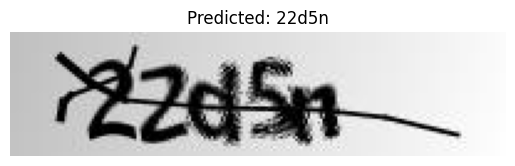

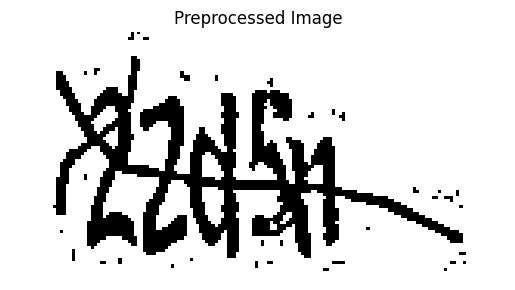

In [24]:
# Test the prediction function
test_image_path = '/kaggle/working/samples/22d5n.png'  # Change this to the path of your test image
predicted_text, confidence_scores = predict_captcha(model, test_image_path, int_to_char)

# Test on an unseen image from the dataset

In [25]:
# Test on an unseen image from the dataset
test_image_index = 12  # Change this index to test different images
test_image_path = os.path.join(folder_path, os.listdir(folder_path)[test_image_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


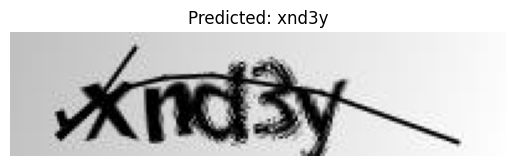

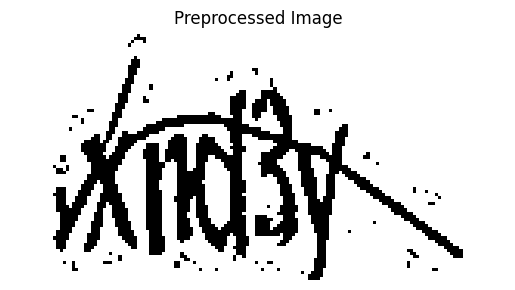

In [26]:
# Predict on the unseen image
predicted_text, confidence_scores = predict_captcha(model, test_image_path, int_to_char)

# Get true label from filename
true_label = os.path.splitext(os.path.basename(test_image_path))[0]

# Display the prediction result, confidence scores, and true label

In [27]:
# Display the prediction result, confidence scores, and true label
print("Prediction Results:")
print(f"Predicted text: {predicted_text}")
print(f"True label: {true_label}")
print("Confidence scores:")
for i, score in enumerate(confidence_scores):
    print(f"Character {i + 1}: {score:.2f}")

Prediction Results:
Predicted text: xnd3y
True label: xnd3y
Confidence scores:
Character 1: 0.93
Character 2: 1.00
Character 3: 0.96
Character 4: 0.86
Character 5: 0.98


# Print training history (Assuming `history` is available from training)

In [28]:
# Print training history (Assuming `history` is available from training)
print("\nTraining History:")
for i in range(label_length):
    print(f"\nCharacter position {i + 1}:")
    print(f"Final training accuracy: {history.history[f'char_{i}_accuracy'][-1]:.2%}")
    print(f"Final validation accuracy: {history.history[f'val_char_{i}_accuracy'][-1]:.2%}")



Training History:

Character position 1:
Final training accuracy: 98.98%
Final validation accuracy: 99.42%

Character position 2:
Final training accuracy: 98.83%
Final validation accuracy: 95.93%

Character position 3:
Final training accuracy: 98.83%
Final validation accuracy: 91.28%

Character position 4:
Final training accuracy: 98.83%
Final validation accuracy: 93.02%

Character position 5:
Final training accuracy: 98.83%
Final validation accuracy: 89.53%


In [29]:
# Save the model
model.save('captcha_ocr_model.h5')

# Prediction Of Number Of Captcha To Ensure The Model Is Good

In [30]:

def display_random_predictions(model, folder_path, int_to_char, num_images=5):
    """Display random images with predictions in a vertical layout."""
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Choose random images
    random_files = random.sample(files, min(num_images, len(files)))
    
    # Adjust the figure size for better visibility
    plt.figure(figsize=(10, 5 * num_images))  # Increase height for vertical layout
    
    for i, filename in enumerate(random_files):
        image_path = os.path.join(folder_path, filename)
        predicted_text, confidence_scores = predict_captcha(model, image_path, int_to_char)
        
        # Load the image for display
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the original image for display
        
        # Create a subplot for each image in a single column
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Hide axes
        
        # Show predicted text below each image
        plt.title(f'Predicted: {predicted_text}')
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Display random predictions from the dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


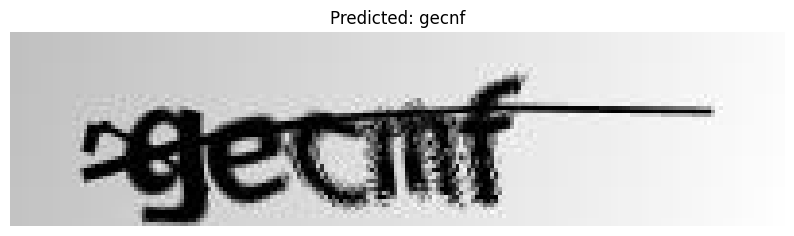

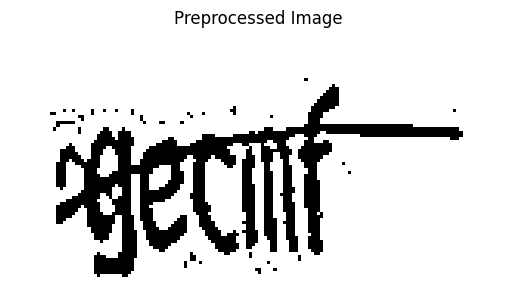

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


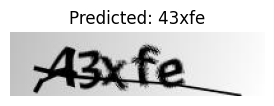

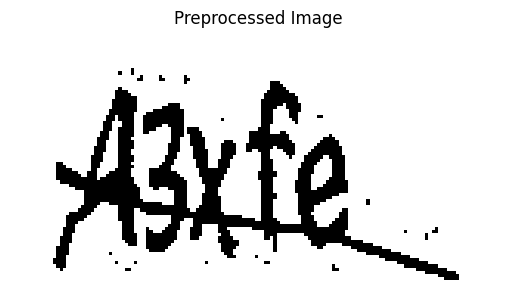

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


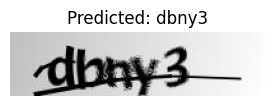

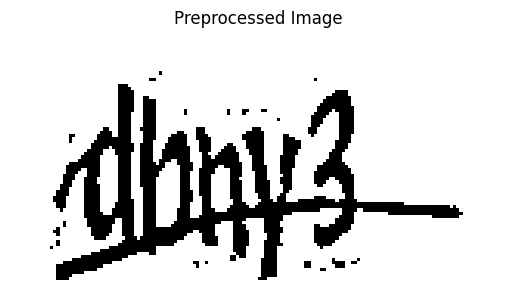

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


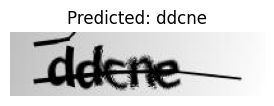

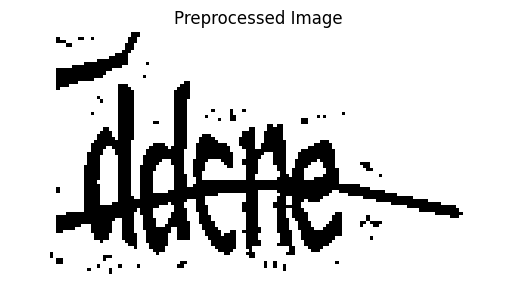

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


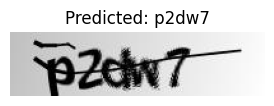

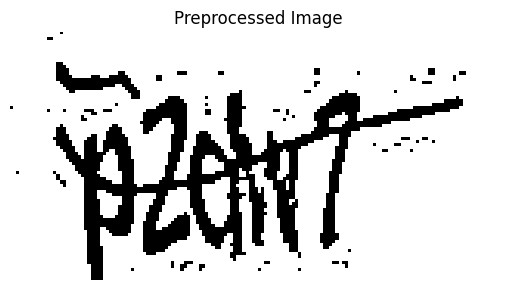

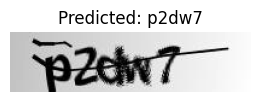

In [31]:
# Display random predictions from the dataset
display_random_predictions(model, folder_path, int_to_char, num_images=5)